In [27]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D, MaxPooling1D, Flatten,LSTM, GRU, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
#!pip install yfinance
#!pip install pandas_ta
import yfinance as yf
import pandas_ta as ta
from sklearn.model_selection import TimeSeriesSplit
import random
import time

In [28]:
random.seed(42)
np.random.seed(42)
tensorflow.random.set_seed(42)

In [29]:
# Helper functions

def get_data(ticker):
  return yf.download(ticker, period='max')

def build_features(data):
  data['SMA'] = ta.sma(data['Close'], length=14)
  data['EMA'] = ta.ema(data['Close'], length=14)
  data['ATR'] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
  data['ADX'] = ta.adx(data['High'], data['Low'], data['Close'], length=14)['ADX_14']
  data['CCI'] = ta.cci(data['High'], data['Low'], data['Close'], length=20)
  data['ROC'] = ta.roc(data['Close'], length=10)
  data['RSI'] = ta.rsi(data['Close'], length=14)
  data['WilliamsR'] = ta.willr(data['High'], data['Low'], data['Close'], length=14)
  data['StochasticK'] = ta.stoch(data['High'], data['Low'], data['Close'])['STOCHk_14_3_3']
  data['StochasticD'] = ta.stoch(data['High'], data['Low'], data['Close'])['STOCHd_14_3_3']
  return data.dropna()

def build_target(data):
  data['Target'] = data['Adj Close'].shift(-1)
  return data.dropna()

def drop_columns(data):
  data.drop(['Open',	'High'	,'Low'	,'Close','Volume'], axis=1, inplace=True)
  return data

def split_to_folds(data):
  tscv = TimeSeriesSplit(n_splits=5)
  folds = []
  for i, (train_val_indices, test_indices) in enumerate(tscv.split(data)):

    train_indices = train_val_indices[:int(len(train_val_indices) * 0.8)]
    val_indices = train_val_indices[int(len(train_val_indices) * 0.8):]

    train_data = data.iloc[train_indices]
    val_data = data.iloc[val_indices]
    test_data = data.iloc[test_indices]

    folds.append((train_data,val_data,test_data))
  return folds

def normalize_data(train,val,test):
  scaler = MinMaxScaler(feature_range=(0, 10))
  train_scaled = scaler.fit_transform(train)
  val_scaled = scaler.transform(val)
  test_scaled = scaler.transform(test)
  return pd.DataFrame(train_scaled, columns=train.columns), pd.DataFrame(val_scaled, columns=val.columns), pd.DataFrame(test_scaled, columns=test.columns), scaler

def split_features_target(data):
  feature_columns = data.columns.drop('Target')
  return np.array(data[feature_columns]), np.array(data[['Target']])

def window_data(data, window_size):
    X, y = [], []
    feature_columns = data.columns.drop('Target')
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i + window_size][feature_columns].values)
        y.append(data.iloc[i + window_size]['Target'])
    return np.array(X), np.array(y)

def prepare_data(ticker, sequence=True):
  data = get_data(ticker)
  data = build_features(data)
  data = build_target(data)
  data = drop_columns(data)
  folds = split_to_folds(data)
  processed_folds = []
  for train, val, test in folds:
    train_scaled, val_scaled, test_scaled, scaler = normalize_data(train, val, test)
    if sequence:
      X_train, y_train = window_data(train_scaled, 30)
      X_val, y_val = window_data(val_scaled, 30)
      X_test, y_test = window_data(test_scaled, 30)
      X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
      X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
      X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
    else:
      X_train, y_train = split_features_target(train_scaled)
      X_val, y_val = split_features_target(val_scaled)
      X_test, y_test = split_features_target(test_scaled)

    processed_folds.append((X_train, y_train, X_val, y_val, X_test, y_test, scaler))
  return processed_folds


def compile_model(model):
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')


[*********************100%%**********************]  1 of 1 completed
<ipython-input-29-1096c092dfd5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = data['Adj Close'].shift(-1)


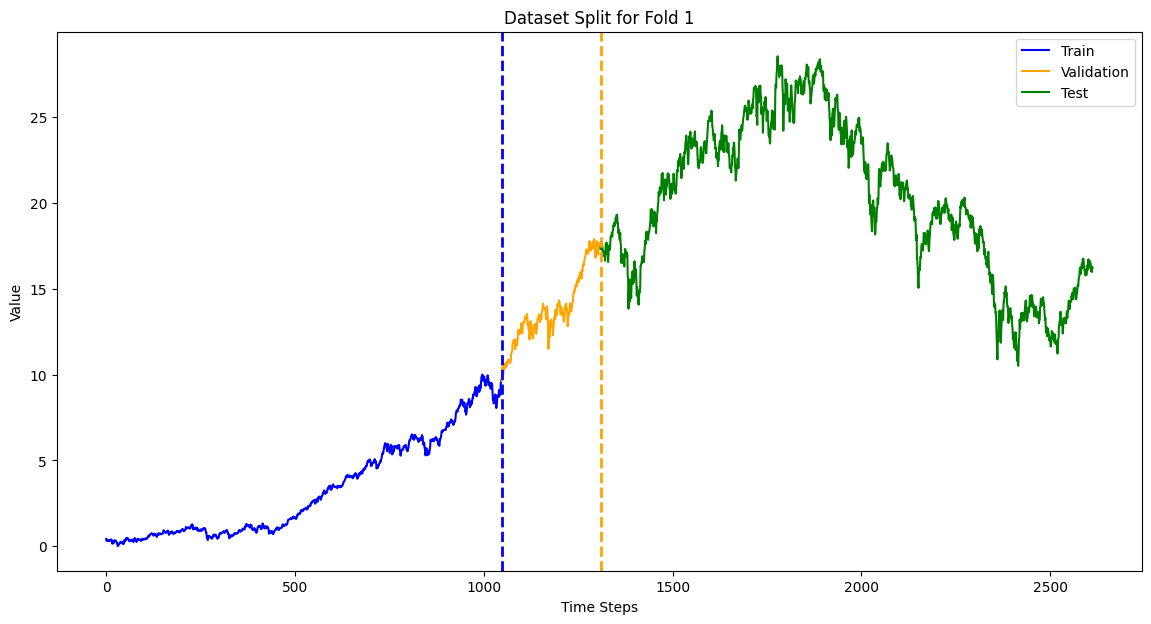

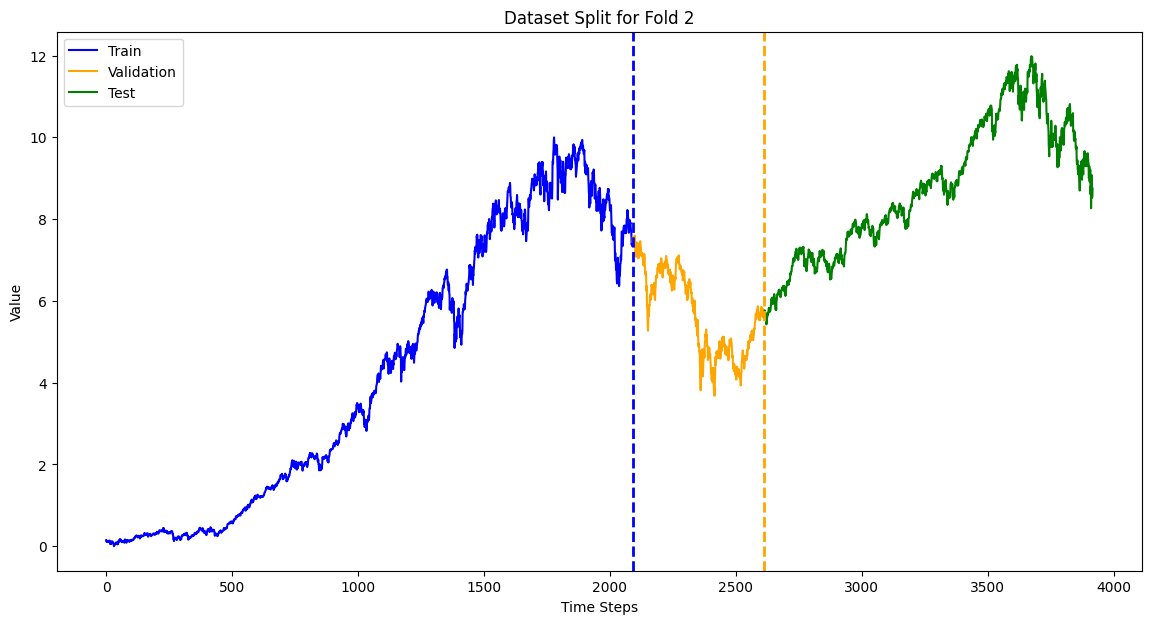

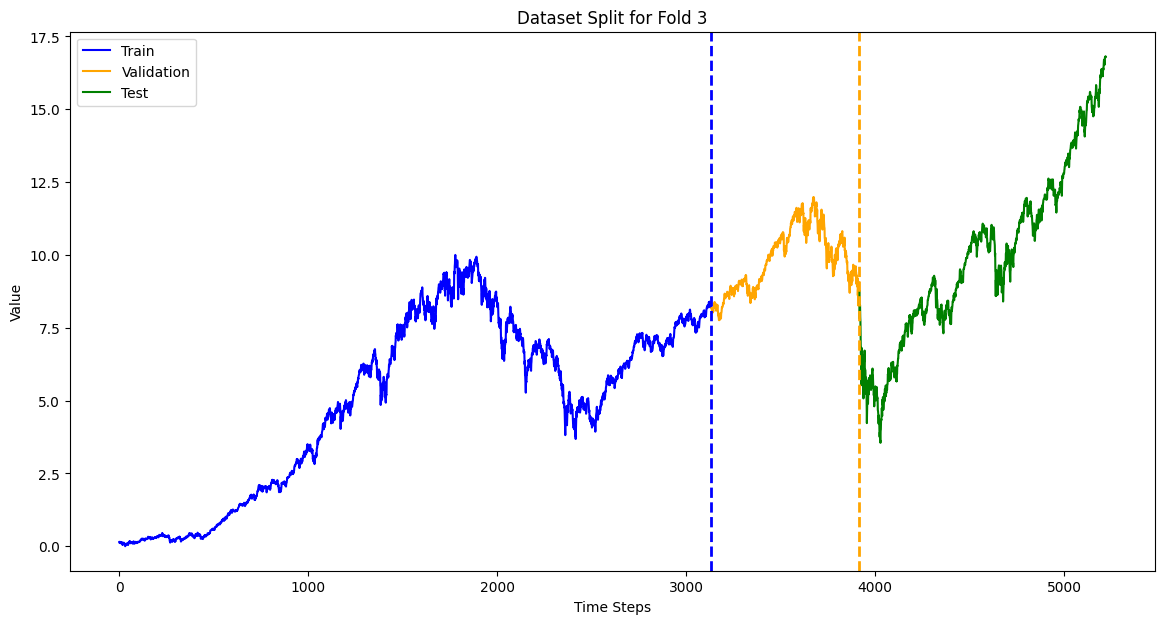

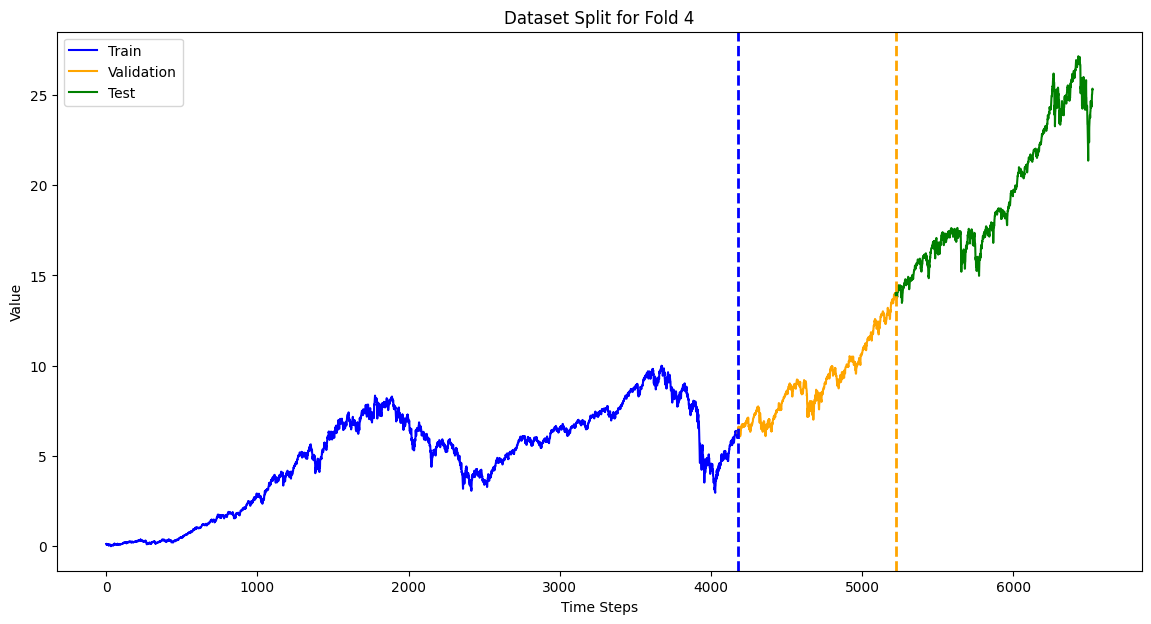

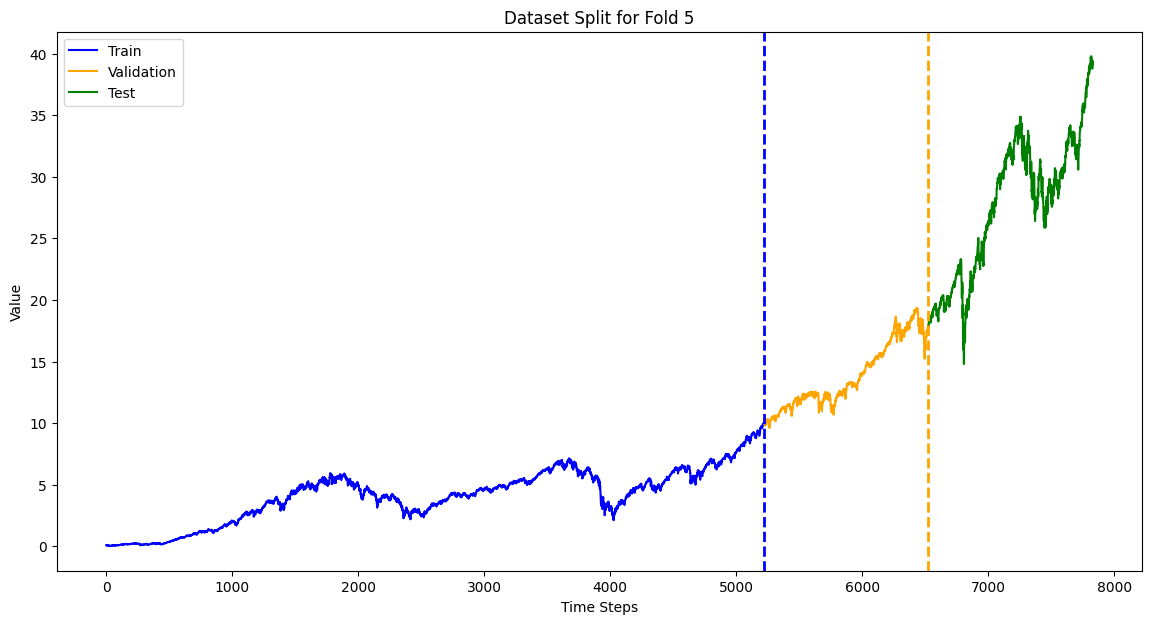

In [30]:
folds = prepare_data("SPY", sequence=False)
for i, (X_train, y_train, X_val, y_val, X_test, y_test, scaler) in enumerate(folds):

  plt.figure(figsize=(14, 7))
  combined_y = np.concatenate([y_train.flatten(), y_val.flatten(), y_test.flatten()])
  x_axis = np.arange(len(combined_y))
  train_end = len(y_train)
  val_end = train_end + len(y_val)
  plt.plot(x_axis[:train_end], combined_y[:train_end], label='Train', color='blue')
  plt.plot(x_axis[train_end:val_end], combined_y[train_end:val_end], label='Validation', color='orange')
  plt.plot(x_axis[val_end:], combined_y[val_end:], label='Test', color='green')
  plt.axvline(x=train_end, color='blue', linestyle='--', lw=2)
  plt.axvline(x=val_end, color='orange', linestyle='--', lw=2)

  plt.title(f'Dataset Split for Fold {i + 1}')
  plt.xlabel('Time Steps')
  plt.ylabel('Value')
  plt.legend()
  plt.show()


In [31]:
# DNN
def create_DNN(input_shape):
  model = Sequential([
      Dense(512, activation='relu', input_shape=(input_shape,)),
      Dense(256, activation='relu'),
      Dense(256, activation='relu'),
      Dense(1)
  ])
  return model

In [32]:
model = create_DNN(11)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 512)               6144      
                                                                 
 dense_39 (Dense)            (None, 256)               131328    
                                                                 
 dense_40 (Dense)            (None, 256)               65792     
                                                                 
 dense_41 (Dense)            (None, 1)                 257       
                                                                 
Total params: 203521 (795.00 KB)
Trainable params: 203521 (795.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
models = []
histories = []
metrics = []
folds = prepare_data("SPY", sequence=False)
predictions = []
times = []
for X_train, y_train, X_val, y_val, X_test, y_test, scaler in folds:

  model = create_DNN(input_shape=11)
  compile_model(model)
  start_time = time.time()
  history = model.fit(
      X_train, y_train,
      epochs=200,
      batch_size=32,
      validation_data=(X_val, y_val),
      callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
  )
  end_time = time.time()
  total_time = end_time - start_time
  times.append(total_time)
  models.append(model)
  histories.append(history)
  y_pred = model.predict(X_test)
  predictions.append((y_test, y_pred))
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mape = mean_absolute_percentage_error(y_test, y_pred)
  metrics.append((rmse, mape))



[*********************100%%**********************]  1 of 1 completed
<ipython-input-29-1096c092dfd5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = data['Adj Close'].shift(-1)


Epoch 1/200
33/33 [==============================] - 2s 8ms/step - loss: 0.7764 - val_loss: 0.2158
Epoch 2/200
33/33 [==============================] - 0s 4ms/step - loss: 0.0431 - val_loss: 0.1655
Epoch 3/200
33/33 [==============================] - 0s 4ms/step - loss: 0.0351 - val_loss: 0.2404
Epoch 4/200
33/33 [==============================] - 0s 5ms/step - loss: 0.0216 - val_loss: 0.3366
Epoch 5/200
33/33 [==============================] - 0s 4ms/step - loss: 0.0249 - val_loss: 0.1480
Epoch 6/200
33/33 [==============================] - 0s 4ms/step - loss: 0.0267 - val_loss: 0.1558
Epoch 7/200
33/33 [==============================] - 0s 4ms/step - loss: 0.0253 - val_loss: 0.4799
Epoch 8/200
33/33 [==============================] - 0s 4ms/step - loss: 0.0277 - val_loss: 0.3025
Epoch 9/200
33/33 [==============================] - 0s 5ms/step - loss: 0.0137 - val_loss: 0.1289
Epoch 10/200
33/33 [==============================] - 0s 4ms/step - loss: 0.0183 - val_loss: 0.1102
Epoch 11/

Total avarage training time: 6.37 seconds

##################################################
#########  FOLD 1 #########
##################################################

Model 1: RMSE = 1.3484, MAPE = 0.0599


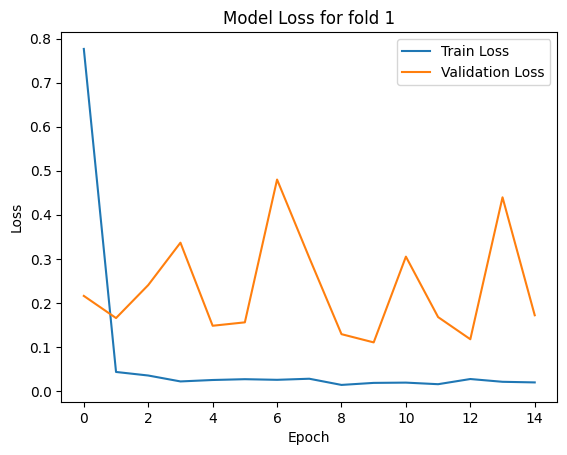

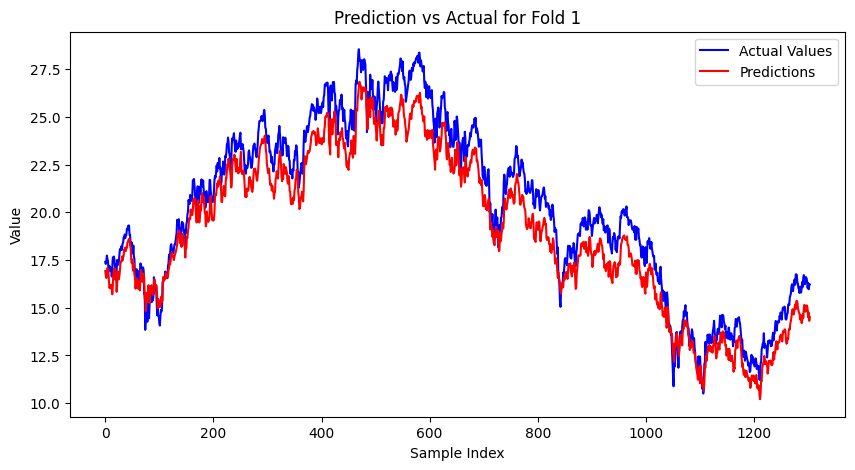


##################################################
#########  FOLD 2 #########
##################################################

Model 2: RMSE = 0.8948, MAPE = 0.0954


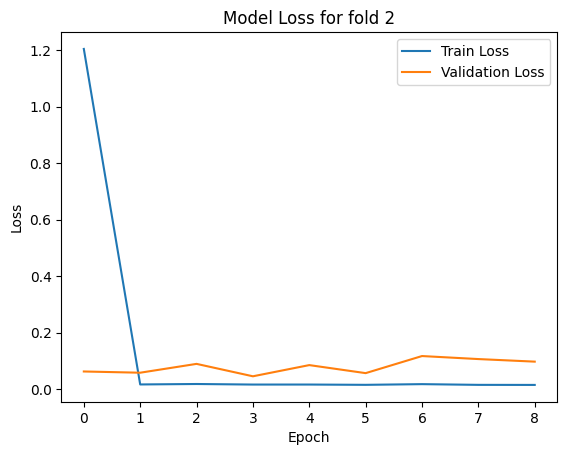

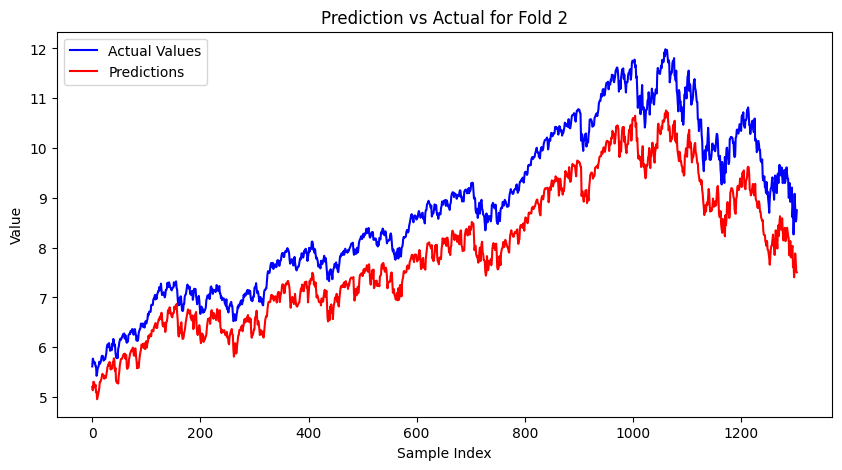


##################################################
#########  FOLD 3 #########
##################################################

Model 3: RMSE = 0.6556, MAPE = 0.0575


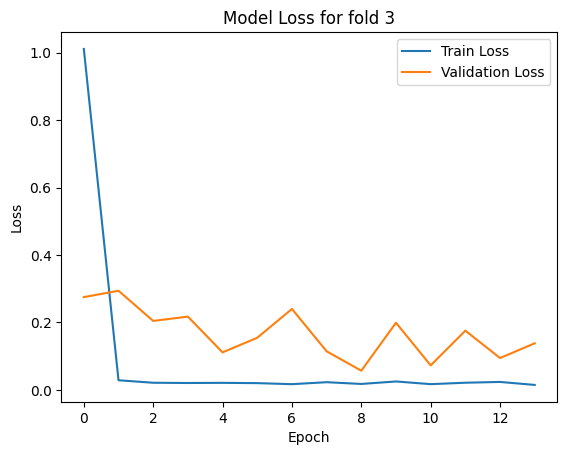

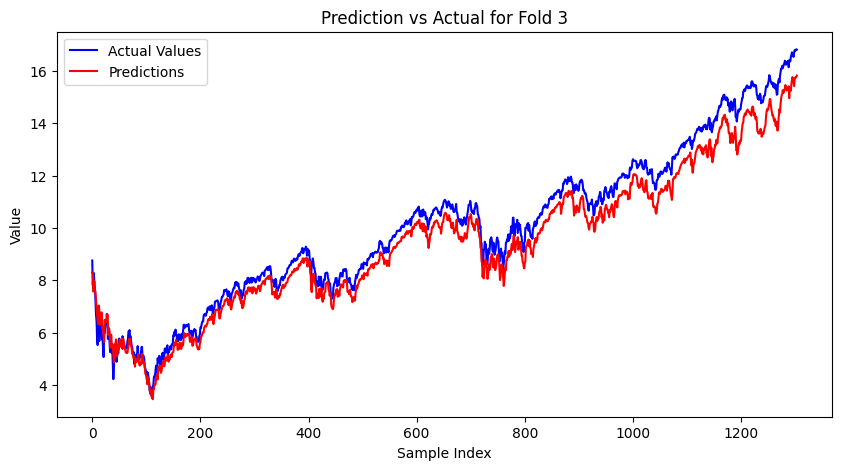


##################################################
#########  FOLD 4 #########
##################################################

Model 4: RMSE = 0.6093, MAPE = 0.0269


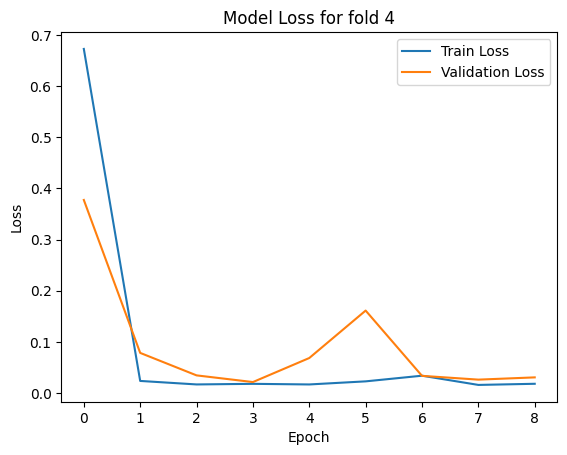

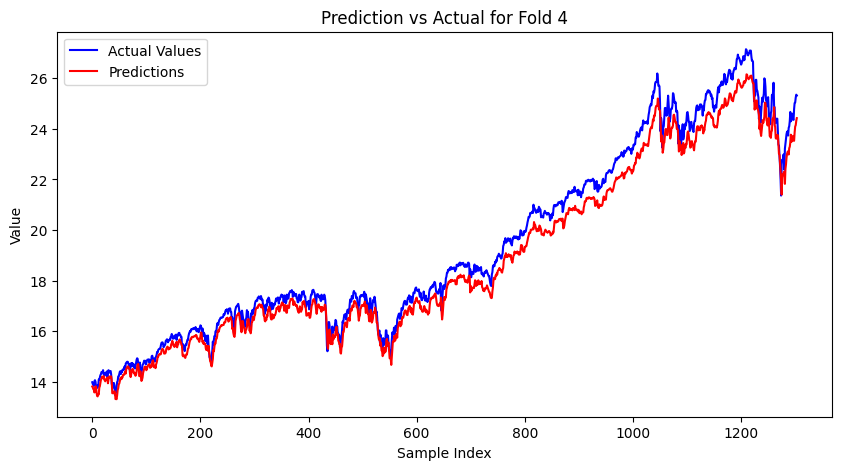


##################################################
#########  FOLD 5 #########
##################################################

Model 5: RMSE = 0.6482, MAPE = 0.0170


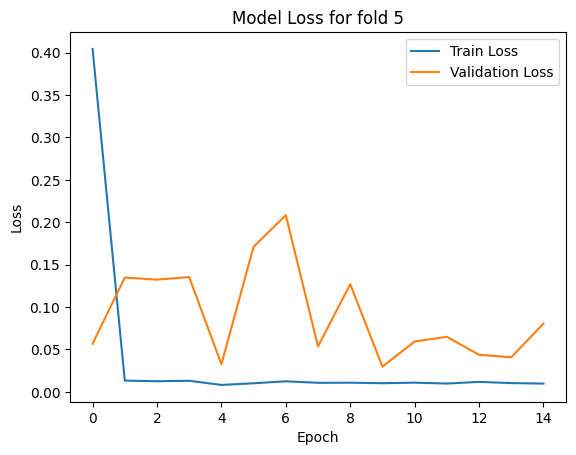

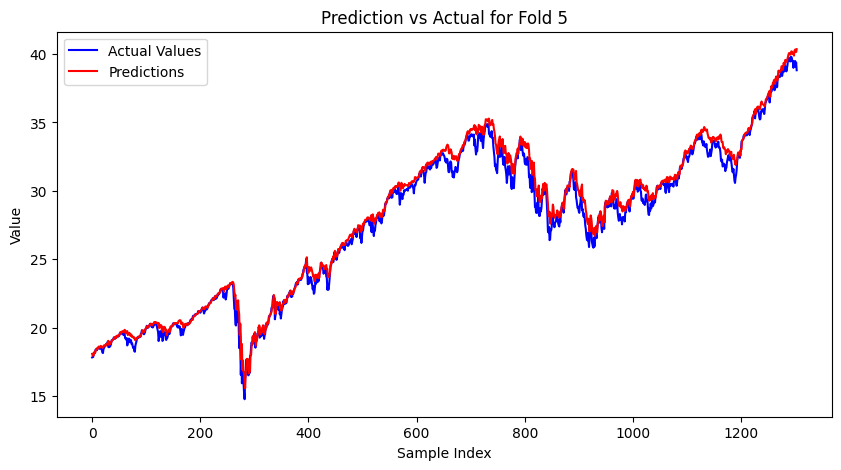

In [34]:
print(f"Total avarage training time: {np.average(times):.2f} seconds")

for fold in range(5):
  history = histories[fold]
  rmse, mape = metrics[fold]
  y_actual, y_hat = predictions[fold]
  print("\n" + "#" * 50)
  print(f"#########  FOLD {fold+1} #########")
  print("#" * 50 + "\n")
  print(f"Model {fold+1}: RMSE = {rmse:.4f}, MAPE = {mape:.4f}")
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'Model Loss for fold {fold + 1}')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()


  plt.figure(figsize=(10, 5))
  plt.plot(y_actual, label='Actual Values', color='blue')
  plt.plot(y_hat, label='Predictions', color='red')
  plt.title(f'Prediction vs Actual for Fold {fold + 1}')
  plt.ylabel('Value')
  plt.xlabel('Sample Index')
  plt.legend()
  plt.show()

In [35]:
# CNN

def create_CNN(input_shape, input_series_length):
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(input_series_length, input_shape)),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(164, activation='relu'),
        Dense(1)
    ])
    return model

In [36]:
model = create_CNN(11,30)
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 28, 128)           4352      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 14, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 12, 128)           49280     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 6, 128)            0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 768)               0         
                                                                 
 dense_62 (Dense)            (None, 164)             

In [37]:
models = []
histories = []
metrics = []
folds = prepare_data("SPY")
predictions = []
times = []
for X_train, y_train, X_val, y_val, X_test, y_test, scaler in folds:

  model = create_CNN(11,30)
  compile_model(model)

  start_time = time.time()
  history = model.fit(
      X_train, y_train,
      epochs=200,
      batch_size=32,
      validation_data=(X_val, y_val),
      callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
  )
  end_time = time.time()
  total_time = end_time - start_time
  times.append(total_time)

  models.append(model)
  histories.append(history)
  y_pred = model.predict(X_test)
  predictions.append((y_test, y_pred))
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mape = mean_absolute_percentage_error(y_test, y_pred)
  metrics.append((rmse, mape))



[*********************100%%**********************]  1 of 1 completed
<ipython-input-29-1096c092dfd5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = data['Adj Close'].shift(-1)


Epoch 1/200
32/32 [==============================] - 3s 17ms/step - loss: 3.1160 - val_loss: 4.7899
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 0.1208 - val_loss: 2.3270
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0770 - val_loss: 1.3944
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0602 - val_loss: 1.1414
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0482 - val_loss: 1.4531
Epoch 6/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0512 - val_loss: 1.1319
Epoch 7/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0454 - val_loss: 1.4423
Epoch 8/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0367 - val_loss: 0.9138
Epoch 9/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0383 - val_loss: 1.8184
Epoch 10/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0352 - val_loss: 2.0757
Epoch 11

Total avarage training time: 9.47 seconds

##################################################
#########  FOLD 1 #########
##################################################

Model 1: RMSE = 2.3859, MAPE = 0.1043


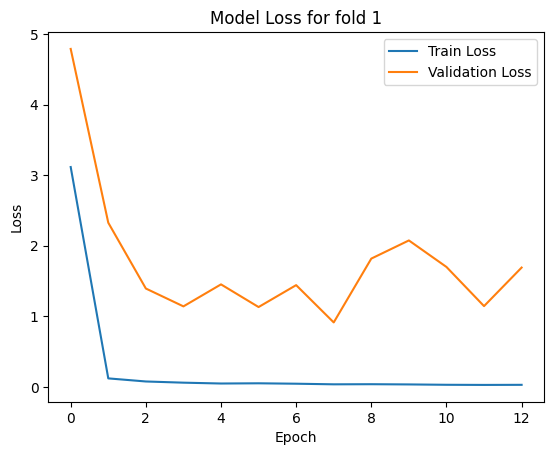

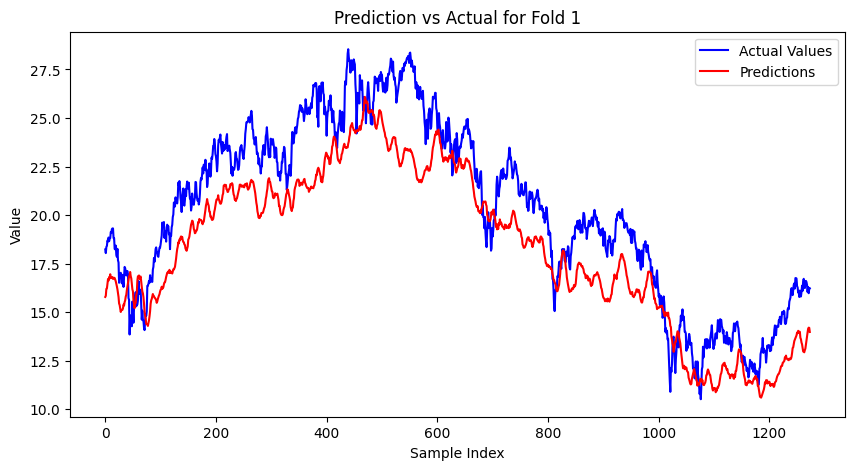


##################################################
#########  FOLD 2 #########
##################################################

Model 2: RMSE = 1.0873, MAPE = 0.1125


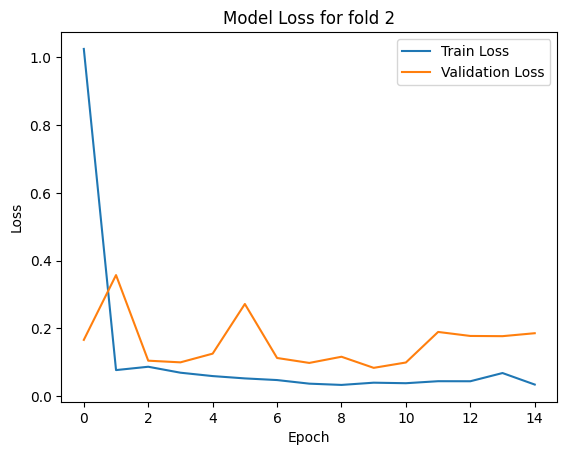

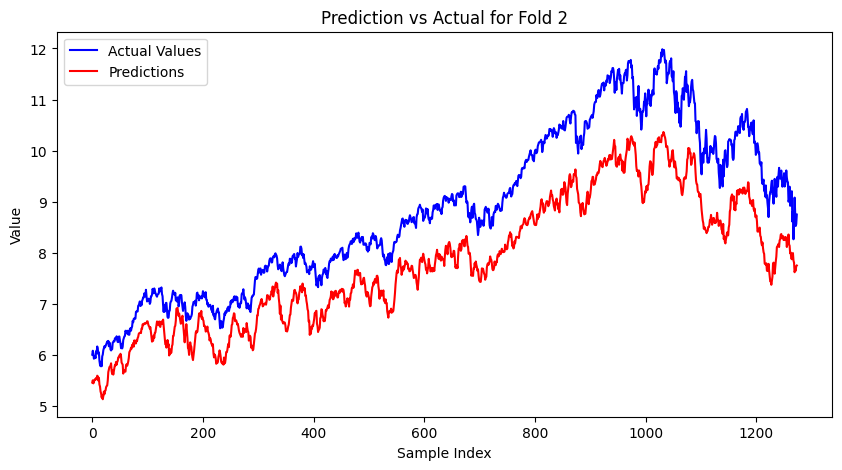


##################################################
#########  FOLD 3 #########
##################################################

Model 3: RMSE = 1.3314, MAPE = 0.1139


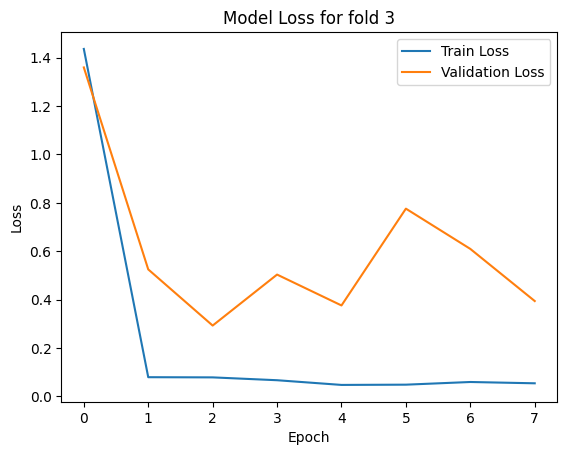

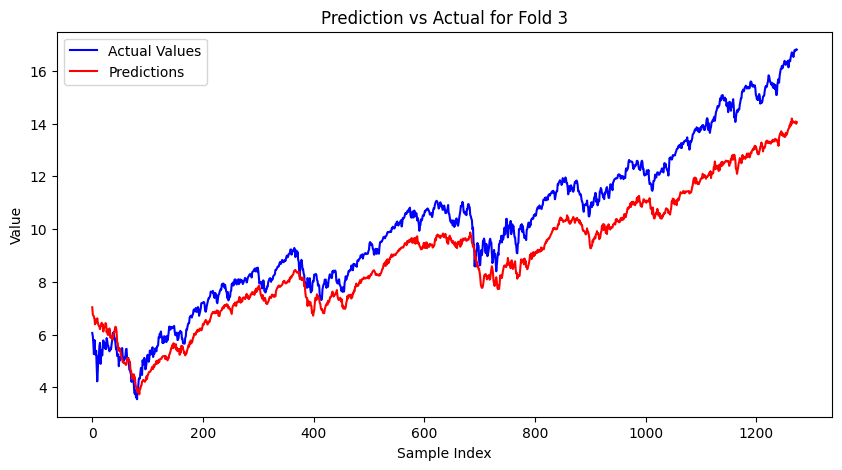


##################################################
#########  FOLD 4 #########
##################################################

Model 4: RMSE = 1.4536, MAPE = 0.0658


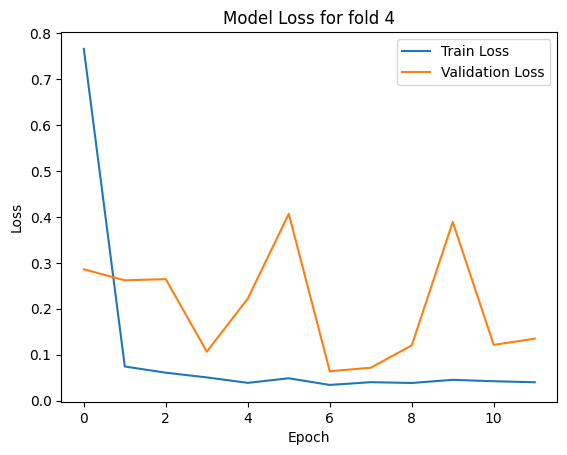

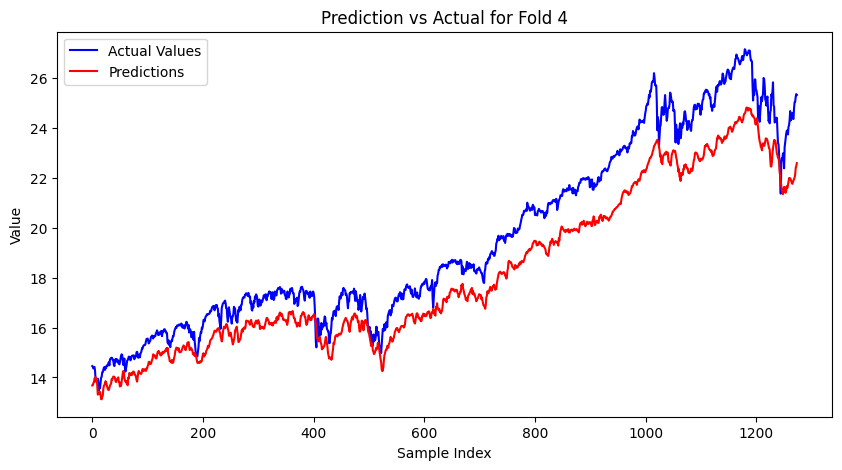


##################################################
#########  FOLD 5 #########
##################################################

Model 5: RMSE = 1.1152, MAPE = 0.0333


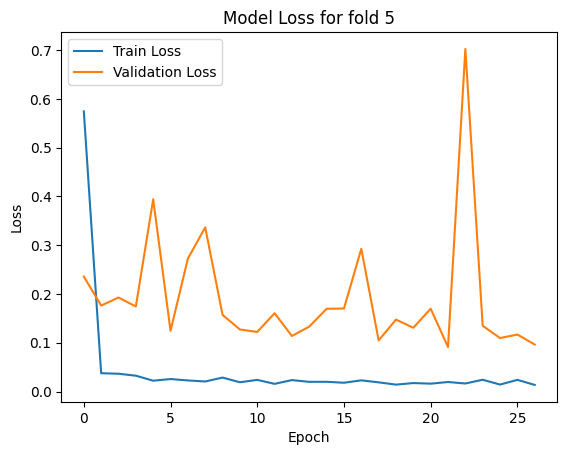

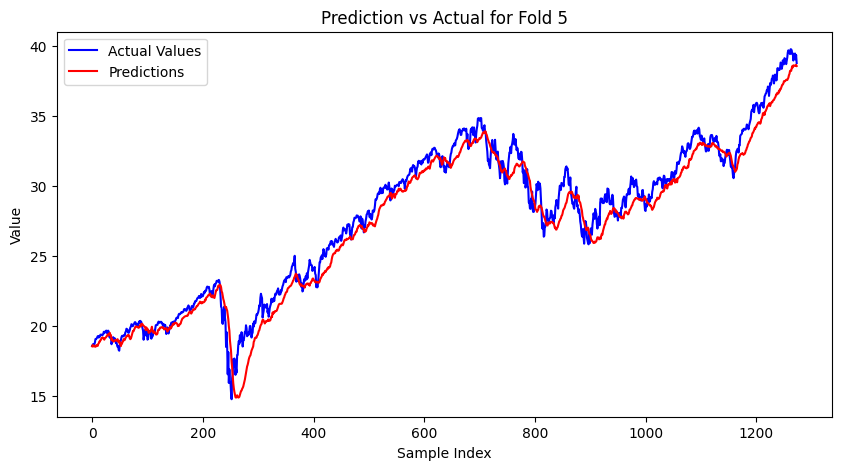

In [38]:
print(f"Total avarage training time: {np.average(times):.2f} seconds")

for fold in range(5):
  history = histories[fold]
  rmse, mape = metrics[fold]
  y_actual, y_hat = predictions[fold]
  print("\n" + "#" * 50)
  print(f"#########  FOLD {fold+1} #########")
  print("#" * 50 + "\n")
  print(f"Model {fold+1}: RMSE = {rmse:.4f}, MAPE = {mape:.4f}")
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'Model Loss for fold {fold + 1}')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()


  plt.figure(figsize=(10, 5))
  plt.plot(y_actual, label='Actual Values', color='blue')
  plt.plot(y_hat, label='Predictions', color='red')
  plt.title(f'Prediction vs Actual for Fold {fold + 1}')
  plt.ylabel('Value')
  plt.xlabel('Sample Index')
  plt.legend()
  plt.show()

In [39]:

def create_LSTM(input_shape,input_series_length):
  model = Sequential([
      LSTM(200, activation='relu', input_shape=(input_series_length, input_shape)),
      Dense(50, activation='relu'),
      Dense(1)
  ])
  return model

In [40]:
model = create_LSTM(11,30)
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               169600    
                                                                 
 dense_74 (Dense)            (None, 50)                10050     
                                                                 
 dense_75 (Dense)            (None, 1)                 51        
                                                                 
Total params: 179701 (701.96 KB)
Trainable params: 179701 (701.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
models = []
histories = []
metrics = []
folds = prepare_data("SPY")
predictions = []
times = []
for X_train, y_train, X_val, y_val, X_test, y_test, scaler in folds:

  model = create_LSTM(11,30)
  compile_model(model)

  start_time = time.time()
  history = model.fit(
      X_train, y_train,
      epochs=200,
      batch_size=32,
      validation_data=(X_val, y_val),
      callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
  )
  end_time = time.time()
  total_time = end_time - start_time
  times.append(total_time)

  models.append(model)
  histories.append(history)
  y_pred = model.predict(X_test)
  predictions.append((y_test, y_pred))
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mape = mean_absolute_percentage_error(y_test, y_pred)
  metrics.append((rmse, mape))



[*********************100%%**********************]  1 of 1 completed
<ipython-input-29-1096c092dfd5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = data['Adj Close'].shift(-1)


Epoch 1/200
32/32 [==============================] - 3s 39ms/step - loss: 2.6049 - val_loss: 0.6967
Epoch 2/200
32/32 [==============================] - 2s 49ms/step - loss: 0.0809 - val_loss: 0.9197
Epoch 3/200
32/32 [==============================] - 1s 45ms/step - loss: 0.0495 - val_loss: 2.0292
Epoch 4/200
32/32 [==============================] - 1s 32ms/step - loss: 0.0390 - val_loss: 2.2210
Epoch 5/200
32/32 [==============================] - 1s 32ms/step - loss: 0.0310 - val_loss: 1.1697
Epoch 6/200
32/32 [==============================] - 1s 33ms/step - loss: 0.0403 - val_loss: 0.6137
Epoch 7/200
32/32 [==============================] - 1s 33ms/step - loss: 0.0535 - val_loss: 0.8072
Epoch 8/200
32/32 [==============================] - 1s 33ms/step - loss: 0.0312 - val_loss: 1.0810
Epoch 9/200
32/32 [==============================] - 1s 33ms/step - loss: 0.0438 - val_loss: 0.6080
Epoch 10/200
32/32 [==============================] - 1s 33ms/step - loss: 0.0383 - val_loss: 0.3828

Epoch 1/200
65/65 [==============================] - 4s 35ms/step - loss: 1.3181 - val_loss: 0.2071
Epoch 2/200
65/65 [==============================] - 2s 33ms/step - loss: 0.0583 - val_loss: 0.4325
Epoch 3/200
65/65 [==============================] - 3s 47ms/step - loss: 0.0558 - val_loss: 0.1153
Epoch 4/200
65/65 [==============================] - 2s 33ms/step - loss: 0.0434 - val_loss: 0.1332
Epoch 5/200
65/65 [==============================] - 2s 34ms/step - loss: 0.0470 - val_loss: 0.1453
Epoch 6/200
65/65 [==============================] - 2s 33ms/step - loss: 0.0413 - val_loss: 0.2445
Epoch 7/200
65/65 [==============================] - 2s 33ms/step - loss: 0.0339 - val_loss: 0.1292
Epoch 8/200
65/65 [==============================] - 3s 47ms/step - loss: 0.0289 - val_loss: 0.0885
Epoch 9/200
65/65 [==============================] - 2s 32ms/step - loss: 0.0343 - val_loss: 0.0952
Epoch 10/200
65/65 [==============================] - 2s 33ms/step - loss: 0.0286 - val_loss: 0.0840

Epoch 1/200
97/97 [==============================] - 6s 37ms/step - loss: 1.9396 - val_loss: 1.3329
Epoch 2/200
97/97 [==============================] - 4s 42ms/step - loss: 0.0457 - val_loss: 0.5083
Epoch 3/200
97/97 [==============================] - 3s 34ms/step - loss: 0.0494 - val_loss: 0.3839
Epoch 4/200
97/97 [==============================] - 3s 35ms/step - loss: 0.0458 - val_loss: 0.4590
Epoch 5/200
97/97 [==============================] - 4s 44ms/step - loss: 0.0315 - val_loss: 0.4679
Epoch 6/200
97/97 [==============================] - 3s 34ms/step - loss: 0.0352 - val_loss: 0.6443
Epoch 7/200
97/97 [==============================] - 3s 33ms/step - loss: 0.0294 - val_loss: 0.3460
Epoch 8/200
97/97 [==============================] - 4s 37ms/step - loss: 0.0324 - val_loss: 0.4588
Epoch 9/200
97/97 [==============================] - 4s 38ms/step - loss: 0.0312 - val_loss: 0.2784
Epoch 10/200
97/97 [==============================] - 3s 33ms/step - loss: 0.0317 - val_loss: 0.3575

Epoch 1/200
130/130 [==============================] - 6s 34ms/step - loss: 1.2943 - val_loss: 0.1965
Epoch 2/200
130/130 [==============================] - 5s 39ms/step - loss: 0.0655 - val_loss: 0.0789
Epoch 3/200
130/130 [==============================] - 4s 33ms/step - loss: 0.0459 - val_loss: 0.0889
Epoch 4/200
130/130 [==============================] - 5s 36ms/step - loss: 0.0378 - val_loss: 0.0738
Epoch 5/200
130/130 [==============================] - 5s 36ms/step - loss: 0.0316 - val_loss: 0.0477
Epoch 6/200
130/130 [==============================] - 4s 33ms/step - loss: 0.0306 - val_loss: 0.1698
Epoch 7/200
130/130 [==============================] - 5s 40ms/step - loss: 0.0340 - val_loss: 0.0530
Epoch 8/200
130/130 [==============================] - 4s 33ms/step - loss: 0.0273 - val_loss: 0.0752
Epoch 9/200
130/130 [==============================] - 4s 33ms/step - loss: 0.0304 - val_loss: 0.0598
Epoch 10/200
130/130 [==============================] - 5s 40ms/step - loss: 0.036

Epoch 1/200
163/163 [==============================] - 7s 34ms/step - loss: 0.5023 - val_loss: 5.3352
Epoch 2/200
163/163 [==============================] - 6s 37ms/step - loss: 0.0347 - val_loss: 0.7451
Epoch 3/200
163/163 [==============================] - 5s 32ms/step - loss: 0.0221 - val_loss: 0.5001
Epoch 4/200
163/163 [==============================] - 6s 37ms/step - loss: 0.0211 - val_loss: 0.1975
Epoch 5/200
163/163 [==============================] - 5s 31ms/step - loss: 0.0203 - val_loss: 0.4436
Epoch 6/200
163/163 [==============================] - 6s 37ms/step - loss: 0.0226 - val_loss: 0.1523
Epoch 7/200
163/163 [==============================] - 5s 31ms/step - loss: 0.0178 - val_loss: 0.1925
Epoch 8/200
163/163 [==============================] - 6s 38ms/step - loss: 0.0211 - val_loss: 1.1211
Epoch 9/200
163/163 [==============================] - 5s 32ms/step - loss: 0.0188 - val_loss: 0.5275
Epoch 10/200
163/163 [==============================] - 5s 32ms/step - loss: 0.018

Total avarage training time: 55.27 seconds

##################################################
#########  FOLD 1 #########
##################################################

Model 1: RMSE = 2.9289, MAPE = 0.1222


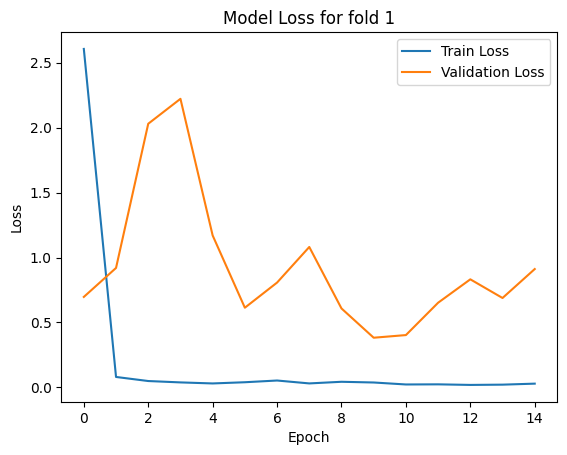

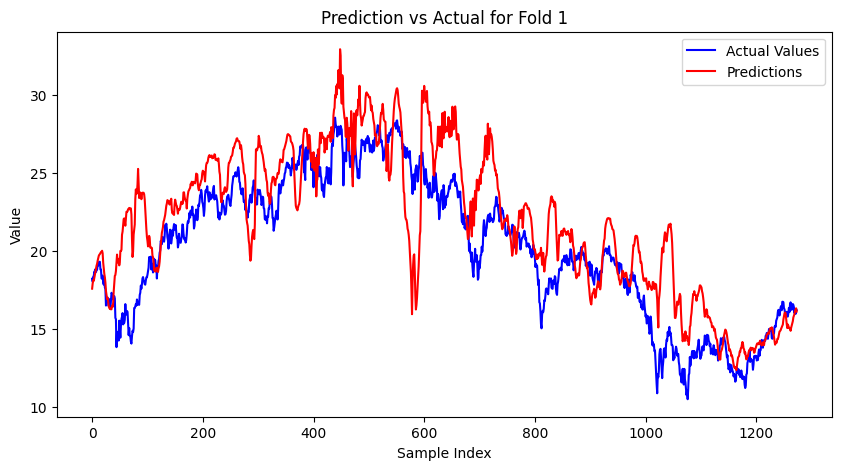


##################################################
#########  FOLD 2 #########
##################################################

Model 2: RMSE = 1.1287, MAPE = 0.1167


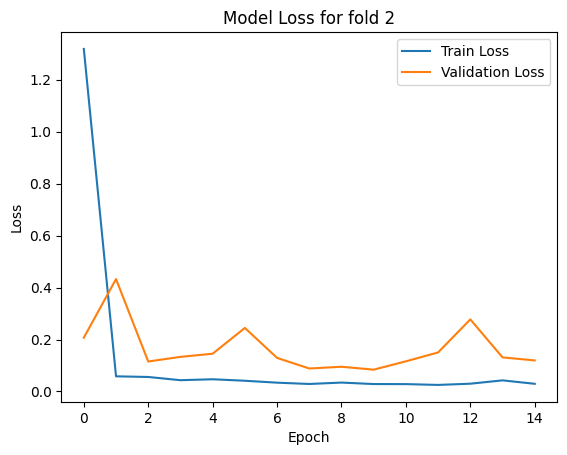

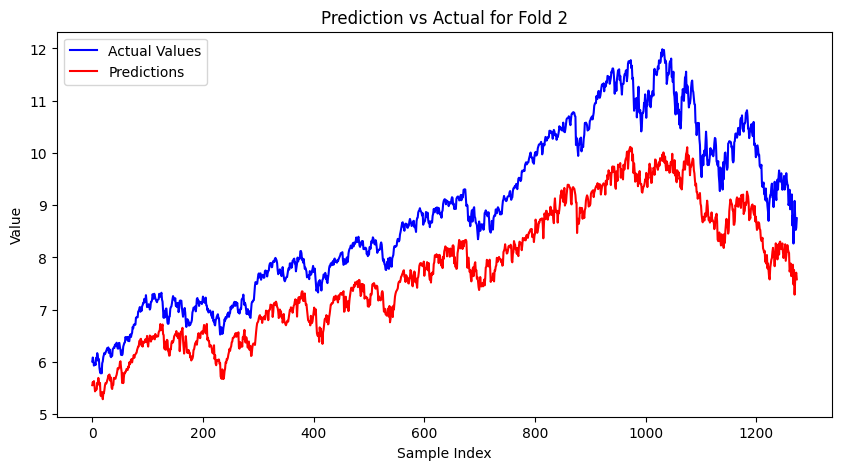


##################################################
#########  FOLD 3 #########
##################################################

Model 3: RMSE = 1.3032, MAPE = 0.1071


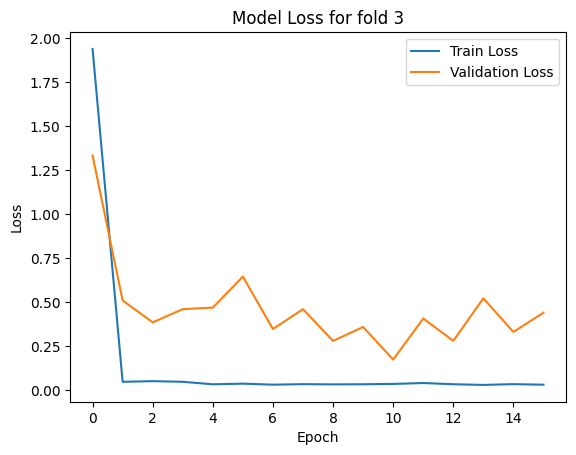

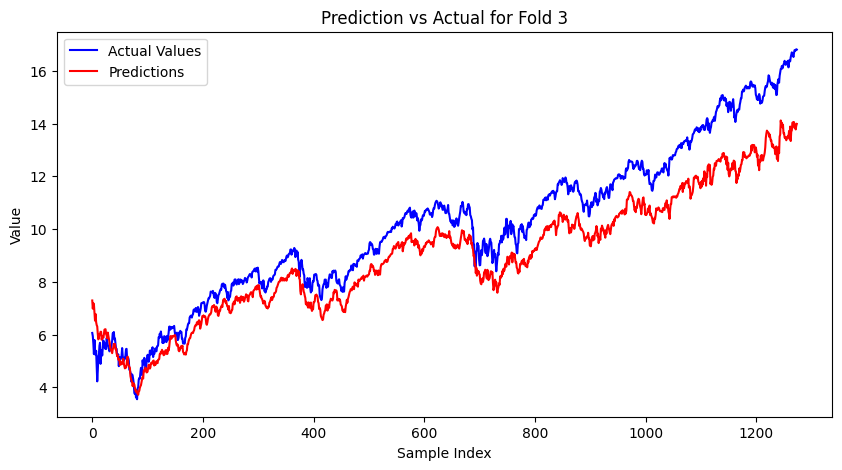


##################################################
#########  FOLD 4 #########
##################################################

Model 4: RMSE = 2.8102, MAPE = 0.0928


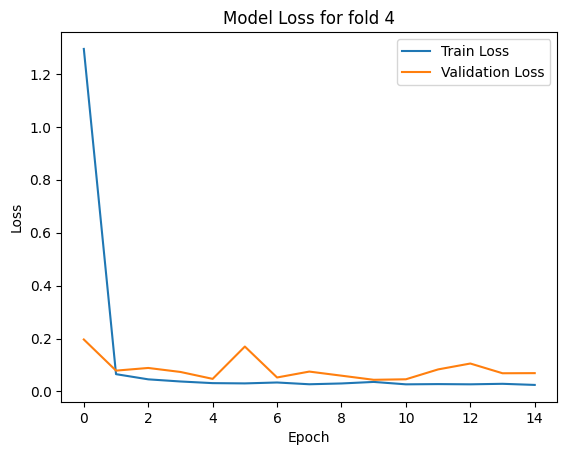

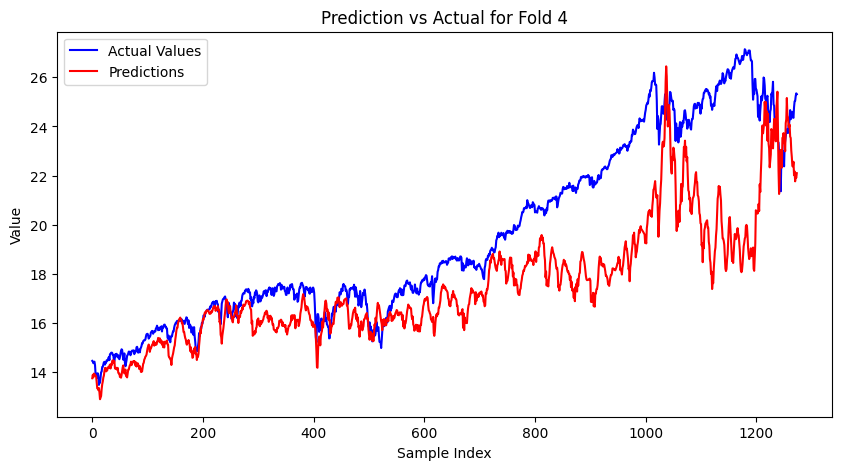


##################################################
#########  FOLD 5 #########
##################################################

Model 5: RMSE = 9.0295, MAPE = 0.2128


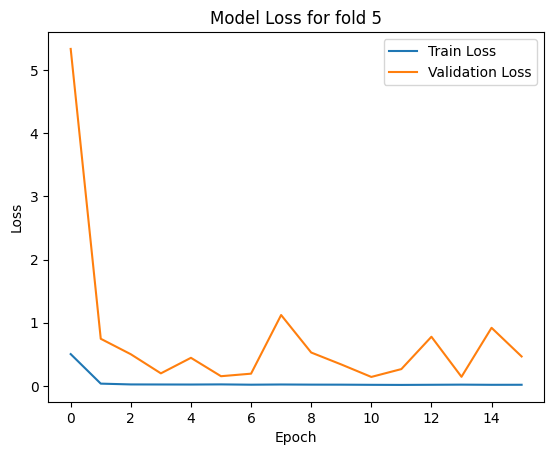

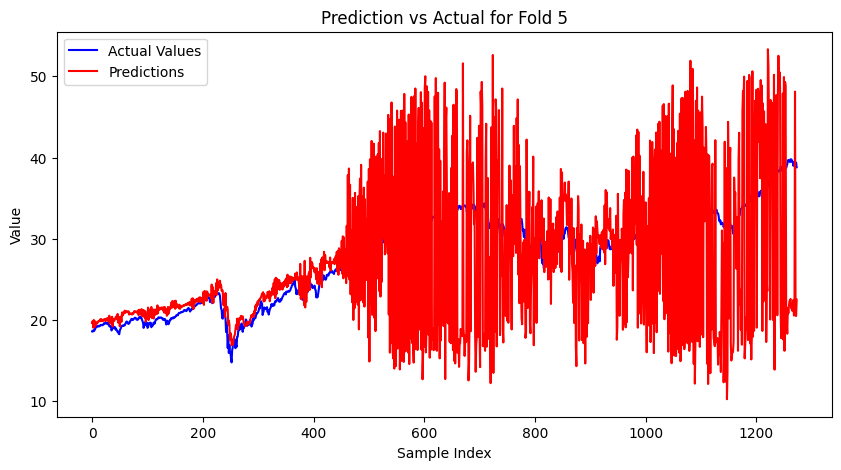

In [42]:
print(f"Total avarage training time: {np.average(times):.2f} seconds")

for fold in range(5):
  history = histories[fold]
  rmse, mape = metrics[fold]
  y_actual, y_hat = predictions[fold]
  print("\n" + "#" * 50)
  print(f"#########  FOLD {fold+1} #########")
  print("#" * 50 + "\n")
  print(f"Model {fold+1}: RMSE = {rmse:.4f}, MAPE = {mape:.4f}")
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'Model Loss for fold {fold + 1}')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()


  plt.figure(figsize=(10, 5))
  plt.plot(y_actual, label='Actual Values', color='blue')
  plt.plot(y_hat, label='Predictions', color='red')
  plt.title(f'Prediction vs Actual for Fold {fold + 1}')
  plt.ylabel('Value')
  plt.xlabel('Sample Index')
  plt.legend()
  plt.show()

In [43]:
def create_GRU(input_shape, input_series_length):
    model = Sequential([
        GRU(256, activation='relu', input_shape=(input_series_length, input_shape), return_sequences=False),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    return model

In [44]:
model = create_GRU(11,30)
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 256)               206592    
                                                                 
 dense_86 (Dense)            (None, 50)                12850     
                                                                 
 dense_87 (Dense)            (None, 1)                 51        
                                                                 
Total params: 219493 (857.39 KB)
Trainable params: 219493 (857.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
models = []
histories = []
metrics = []
folds = prepare_data("SPY")
predictions = []
times = []
for X_train, y_train, X_val, y_val, X_test, y_test, scaler in folds:

  model = create_GRU(11,30)
  compile_model(model)

  start_time = time.time()
  history = model.fit(
      X_train, y_train,
      epochs=200,
      batch_size=32,
      validation_data=(X_val, y_val),
      callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
  )
  end_time = time.time()
  total_time = end_time - start_time
  times.append(total_time)

  models.append(model)
  histories.append(history)
  y_pred = model.predict(X_test)
  predictions.append((y_test, y_pred))
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mape = mean_absolute_percentage_error(y_test, y_pred)
  metrics.append((rmse, mape))



[*********************100%%**********************]  1 of 1 completed
<ipython-input-29-1096c092dfd5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = data['Adj Close'].shift(-1)


Epoch 1/200
32/32 [==============================] - 4s 47ms/step - loss: 2.3535 - val_loss: 1.2568
Epoch 2/200
32/32 [==============================] - 1s 42ms/step - loss: 0.0466 - val_loss: 0.7535
Epoch 3/200
32/32 [==============================] - 1s 41ms/step - loss: 0.0333 - val_loss: 0.3250
Epoch 4/200
32/32 [==============================] - 1s 42ms/step - loss: 0.0340 - val_loss: 0.5449
Epoch 5/200
32/32 [==============================] - 1s 42ms/step - loss: 0.0313 - val_loss: 0.2902
Epoch 6/200
32/32 [==============================] - 1s 42ms/step - loss: 0.0354 - val_loss: 0.4906
Epoch 7/200
32/32 [==============================] - 2s 55ms/step - loss: 0.0293 - val_loss: 0.6834
Epoch 8/200
32/32 [==============================] - 2s 63ms/step - loss: 0.0381 - val_loss: 0.3592
Epoch 9/200
32/32 [==============================] - 1s 42ms/step - loss: 0.0352 - val_loss: 0.5232
Epoch 10/200
40/40 [==============================] - 0s 7ms/step


Epoch 1/200
65/65 [==============================] - 5s 52ms/step - loss: 1.4729 - val_loss: 0.1573
Epoch 2/200
65/65 [==============================] - 3s 42ms/step - loss: 0.0345 - val_loss: 0.1104
Epoch 3/200
65/65 [==============================] - 3s 41ms/step - loss: 0.0264 - val_loss: 0.0687
Epoch 4/200
65/65 [==============================] - 3s 48ms/step - loss: 0.0305 - val_loss: 0.2208
Epoch 5/200
65/65 [==============================] - 3s 52ms/step - loss: 0.0291 - val_loss: 0.1708
Epoch 6/200
65/65 [==============================] - 3s 41ms/step - loss: 0.0265 - val_loss: 0.1719
Epoch 7/200
65/65 [==============================] - 3s 42ms/step - loss: 0.0248 - val_loss: 0.0883
Epoch 8/200
40/40 [==============================] - 1s 9ms/step


Epoch 1/200
97/97 [==============================] - 7s 44ms/step - loss: 1.0918 - val_loss: 0.7168
Epoch 2/200
97/97 [==============================] - 4s 44ms/step - loss: 0.0446 - val_loss: 0.6114
Epoch 3/200
97/97 [==============================] - 5s 51ms/step - loss: 0.0389 - val_loss: 0.5554
Epoch 4/200
97/97 [==============================] - 4s 42ms/step - loss: 0.0358 - val_loss: 0.4832
Epoch 5/200
97/97 [==============================] - 5s 53ms/step - loss: 0.0314 - val_loss: 0.3543
Epoch 6/200
97/97 [==============================] - 4s 41ms/step - loss: 0.0329 - val_loss: 0.5632
Epoch 7/200
97/97 [==============================] - 4s 42ms/step - loss: 0.0334 - val_loss: 0.3688
Epoch 8/200
97/97 [==============================] - 5s 53ms/step - loss: 0.0292 - val_loss: 0.4658
Epoch 9/200
97/97 [==============================] - 4s 43ms/step - loss: 0.0291 - val_loss: 0.4321
Epoch 10/200
97/97 [==============================] - 4s 43ms/step - loss: 0.0291 - val_loss: 0.2769

Epoch 1/200
130/130 [==============================] - 7s 43ms/step - loss: 1.0569 - val_loss: 0.9595
Epoch 2/200
130/130 [==============================] - 6s 50ms/step - loss: 0.0537 - val_loss: 0.2003
Epoch 3/200
130/130 [==============================] - 5s 42ms/step - loss: 0.0384 - val_loss: 0.1110
Epoch 4/200
130/130 [==============================] - 6s 50ms/step - loss: 0.0306 - val_loss: 0.1860
Epoch 5/200
130/130 [==============================] - 5s 42ms/step - loss: 0.0286 - val_loss: 0.1899
Epoch 6/200
130/130 [==============================] - 6s 49ms/step - loss: 0.0258 - val_loss: 0.2189
Epoch 7/200
130/130 [==============================] - 5s 41ms/step - loss: 0.0265 - val_loss: 0.0915
Epoch 8/200
130/130 [==============================] - 6s 50ms/step - loss: 0.0226 - val_loss: 0.0609
Epoch 9/200
130/130 [==============================] - 5s 41ms/step - loss: 0.0259 - val_loss: 0.0975
Epoch 10/200
130/130 [==============================] - 6s 50ms/step - loss: 0.028

Epoch 1/200
163/163 [==============================] - 9s 43ms/step - loss: 0.5385 - val_loss: 0.5308
Epoch 2/200
163/163 [==============================] - 8s 48ms/step - loss: 0.0210 - val_loss: 0.7813
Epoch 3/200
163/163 [==============================] - 8s 47ms/step - loss: 0.0182 - val_loss: 0.5656
Epoch 4/200
163/163 [==============================] - 7s 41ms/step - loss: 0.0188 - val_loss: 0.6863
Epoch 5/200
163/163 [==============================] - 8s 48ms/step - loss: 0.0171 - val_loss: 0.6893
Epoch 6/200
40/40 [==============================] - 1s 9ms/step


Total avarage training time: 48.21 seconds

##################################################
#########  FOLD 1 #########
##################################################

Model 1: RMSE = 2.5471, MAPE = 0.1070


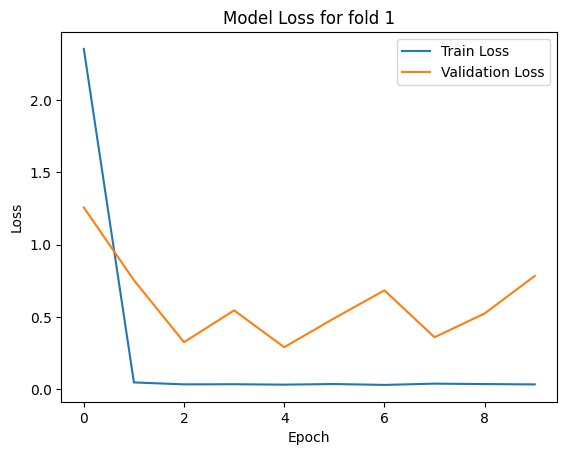

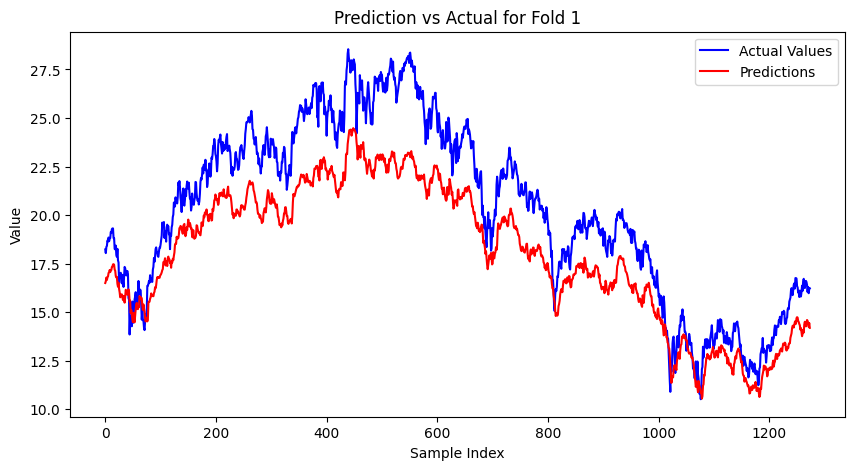


##################################################
#########  FOLD 2 #########
##################################################

Model 2: RMSE = 0.9590, MAPE = 0.1022


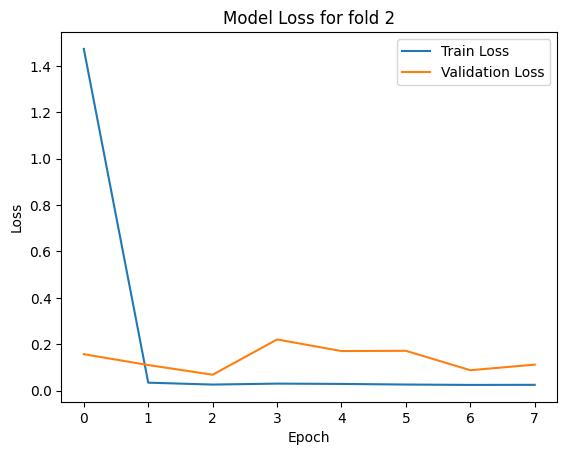

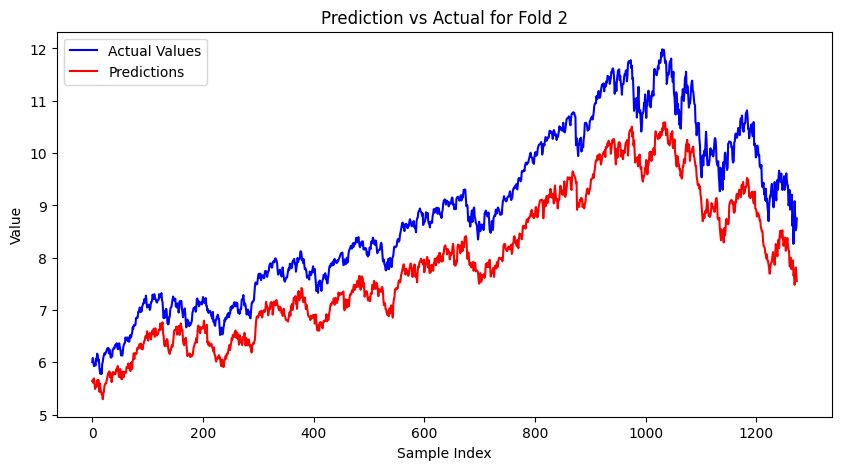


##################################################
#########  FOLD 3 #########
##################################################

Model 3: RMSE = 1.1330, MAPE = 0.0978


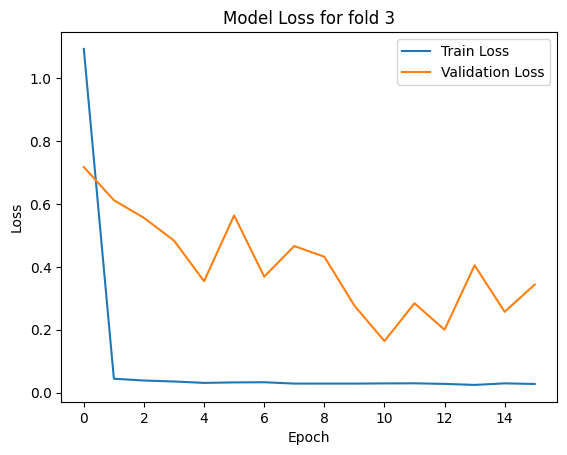

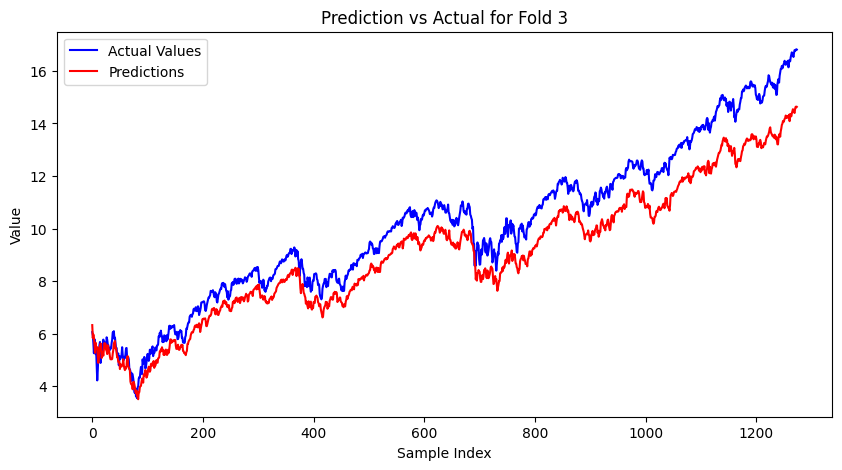


##################################################
#########  FOLD 4 #########
##################################################

Model 4: RMSE = 2.7296, MAPE = 0.1193


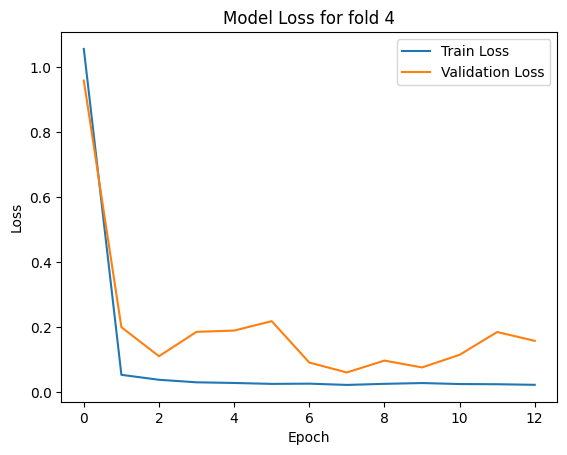

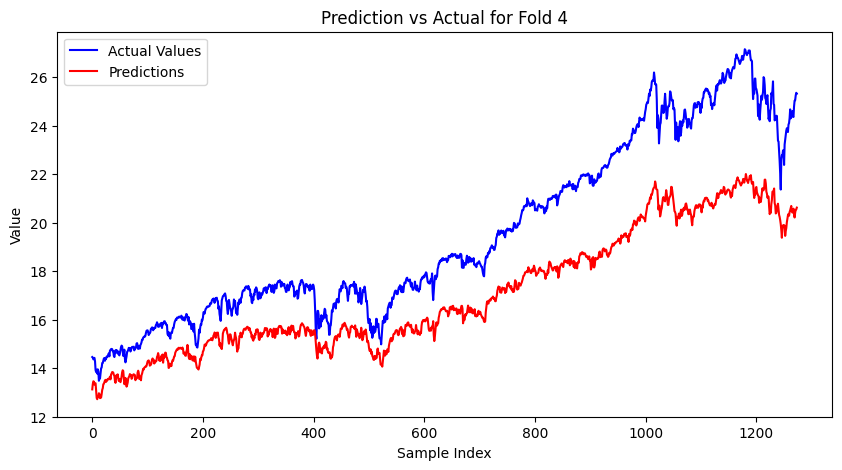


##################################################
#########  FOLD 5 #########
##################################################

Model 5: RMSE = 4.3395, MAPE = 0.1409


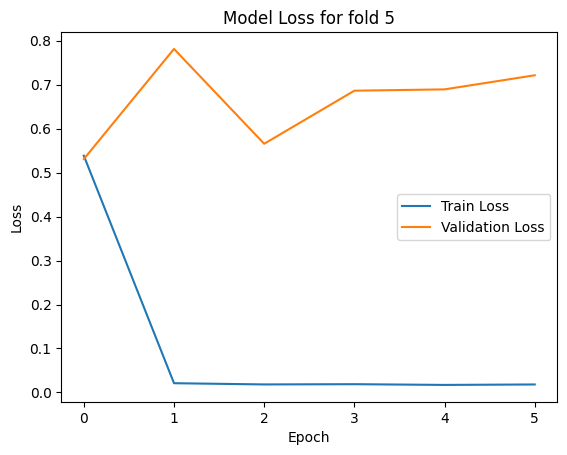

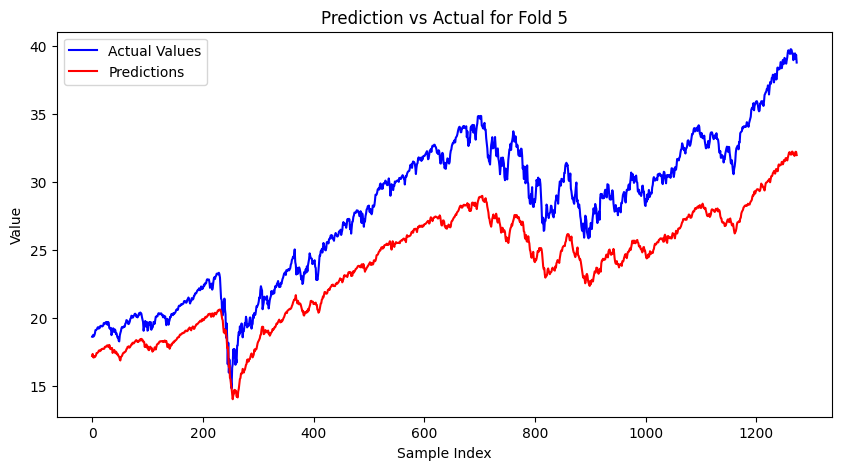

In [46]:
print(f"Total avarage training time: {np.average(times):.2f} seconds")

for fold in range(5):
  history = histories[fold]
  rmse, mape = metrics[fold]
  y_actual, y_hat = predictions[fold]
  print("\n" + "#" * 50)
  print(f"#########  FOLD {fold+1} #########")
  print("#" * 50 + "\n")
  print(f"Model {fold+1}: RMSE = {rmse:.4f}, MAPE = {mape:.4f}")
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'Model Loss for fold {fold + 1}')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()


  plt.figure(figsize=(10, 5))
  plt.plot(y_actual, label='Actual Values', color='blue')
  plt.plot(y_hat, label='Predictions', color='red')
  plt.title(f'Prediction vs Actual for Fold {fold + 1}')
  plt.ylabel('Value')
  plt.xlabel('Sample Index')
  plt.legend()
  plt.show()

In [47]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
  x = LayerNormalization(epsilon=1e-6)(inputs)
  x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
  x = Dropout(dropout)(x)
  res = x + inputs

  x = LayerNormalization(epsilon=1e-6)(res)
  x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = Dropout(dropout)(x)
  x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def create_transformer(input_shape, input_series_length):
  inputs = Input(shape=(input_series_length, input_shape))
  x = inputs
  for _ in range(3):
    x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=256, dropout=0.1)
  #x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)
  x = GlobalAveragePooling1D(data_format="channels_first")(x)
  x = Dense(512, activation="relu")(x)
  x = Dropout(0)(x)
  outputs = Dense(1)(x)
  model = Model(inputs, outputs)
  return model


In [48]:
model = create_transformer(11,30)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30, 11)]             0         []                            
                                                                                                  
 layer_normalization_6 (Lay  (None, 30, 11)               22        ['input_2[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_3 (Mu  (None, 30, 11)               48139     ['layer_normalization_6[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_6[0][0]
                                                                    ']                      

In [49]:
models = []
histories = []
metrics = []
folds = prepare_data("SPY")
predictions = []
times = []
for X_train, y_train, X_val, y_val, X_test, y_test, scaler in folds:

  model = create_transformer(11,30)
  compile_model(model)

  start_time = time.time()
  history = model.fit(
      X_train, y_train,
      epochs=200,
      batch_size=32,
      validation_data=(X_val, y_val),
      callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
  )
  end_time = time.time()
  total_time = end_time - start_time
  times.append(total_time)

  models.append(model)
  histories.append(history)
  y_pred = model.predict(X_test)
  predictions.append((y_test, y_pred))
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mape = mean_absolute_percentage_error(y_test, y_pred)
  metrics.append((rmse, mape))



[*********************100%%**********************]  1 of 1 completed
<ipython-input-29-1096c092dfd5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = data['Adj Close'].shift(-1)


Epoch 1/200
32/32 [==============================] - 11s 34ms/step - loss: 1.6678 - val_loss: 6.6348
Epoch 2/200
32/32 [==============================] - 0s 15ms/step - loss: 0.1169 - val_loss: 4.4218
Epoch 3/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0660 - val_loss: 2.7816
Epoch 4/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0492 - val_loss: 1.9625
Epoch 5/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0430 - val_loss: 1.3362
Epoch 6/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0390 - val_loss: 1.8945
Epoch 7/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0367 - val_loss: 1.9229
Epoch 8/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0440 - val_loss: 1.1264
Epoch 9/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0546 - val_loss: 1.4755
Epoch 10/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0334 - val_loss: 2.157

Total avarage training time: 28.31 seconds

##################################################
#########  FOLD 1 #########
##################################################

Model 1: RMSE = 5.1096, MAPE = 0.2089


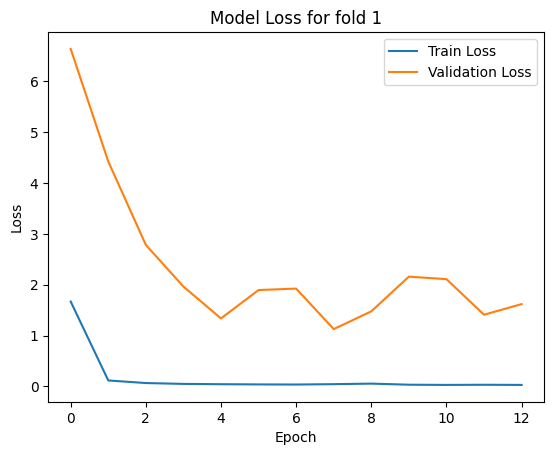

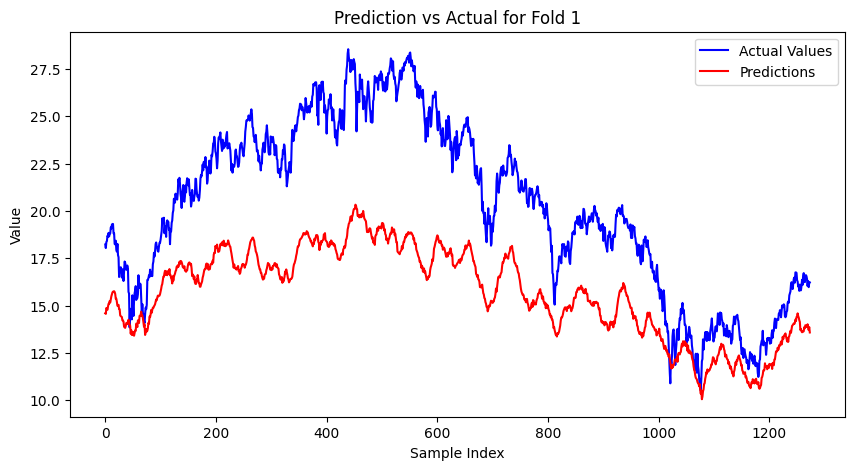


##################################################
#########  FOLD 2 #########
##################################################

Model 2: RMSE = 0.9815, MAPE = 0.1042


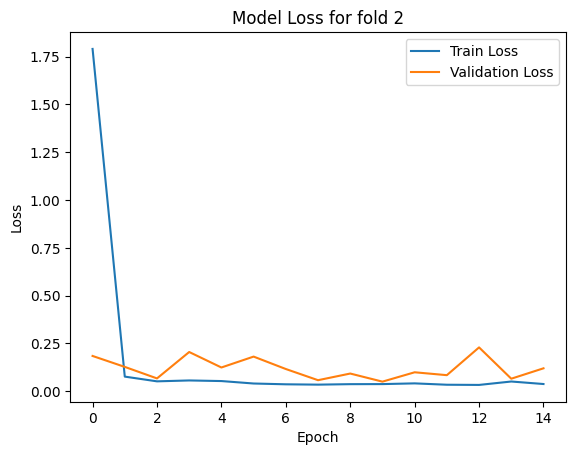

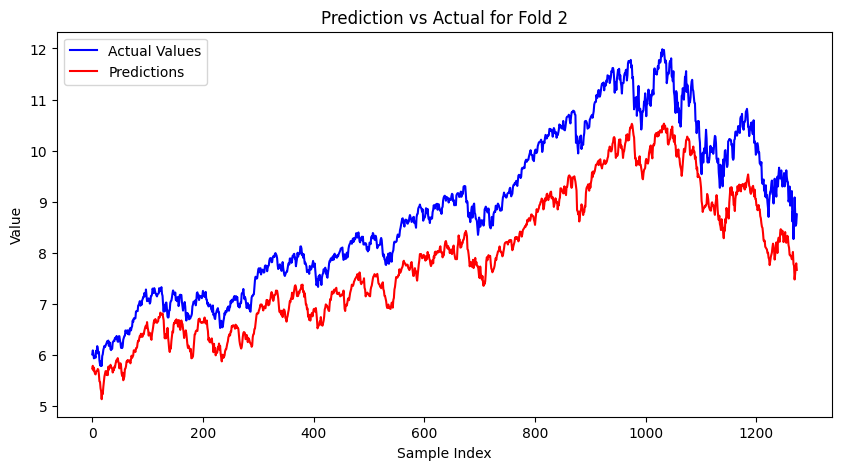


##################################################
#########  FOLD 3 #########
##################################################

Model 3: RMSE = 1.1493, MAPE = 0.0746


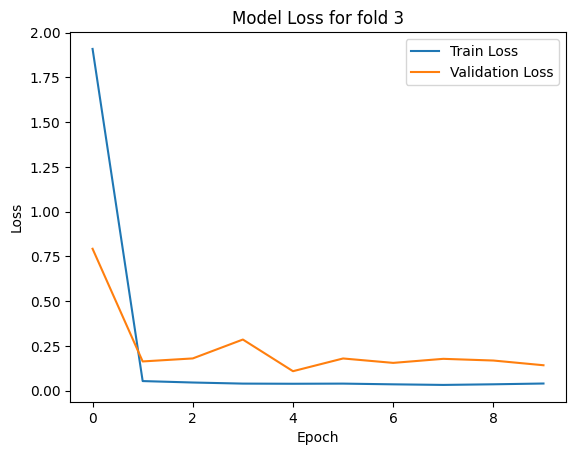

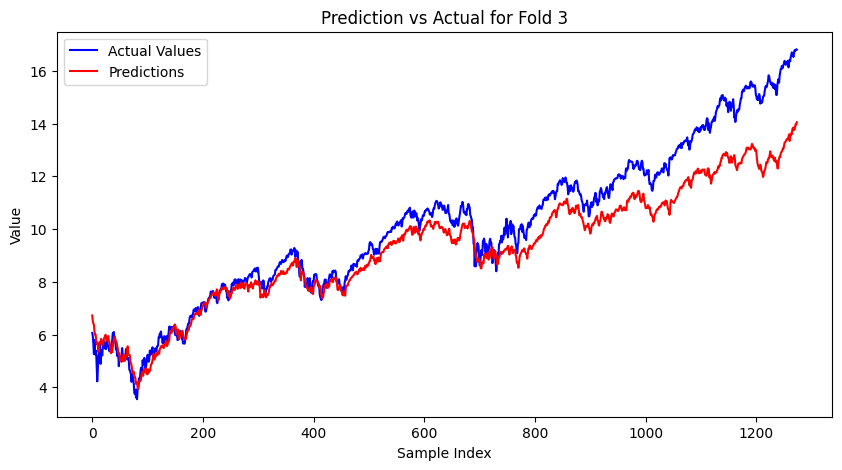


##################################################
#########  FOLD 4 #########
##################################################

Model 4: RMSE = 4.8955, MAPE = 0.2177


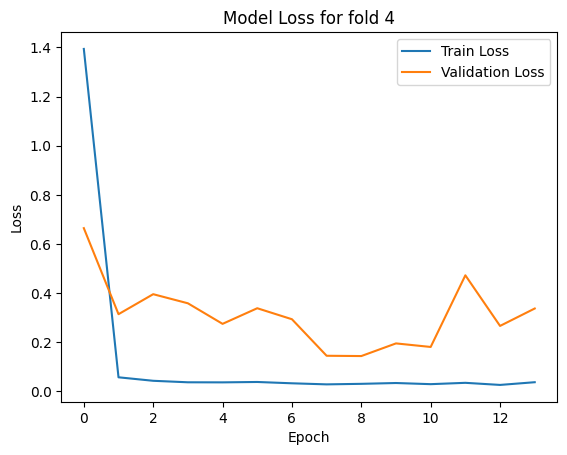

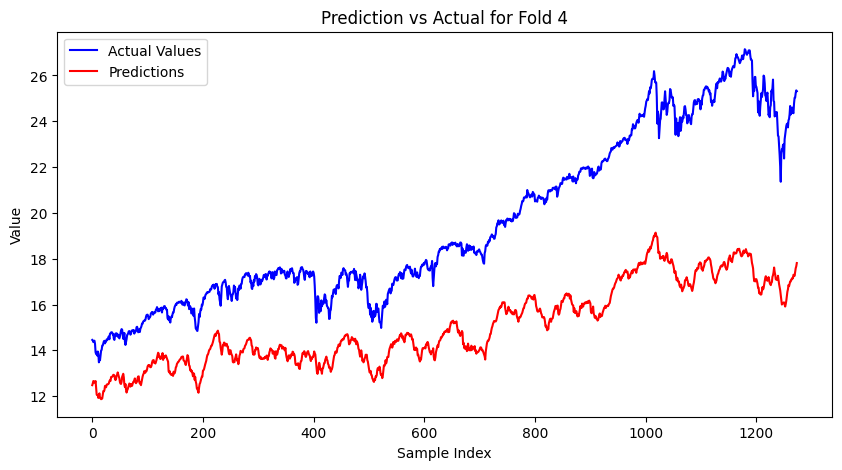


##################################################
#########  FOLD 5 #########
##################################################

Model 5: RMSE = 8.5890, MAPE = 0.2685


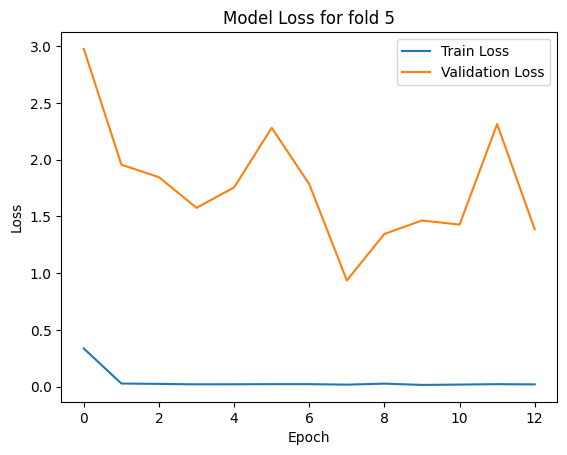

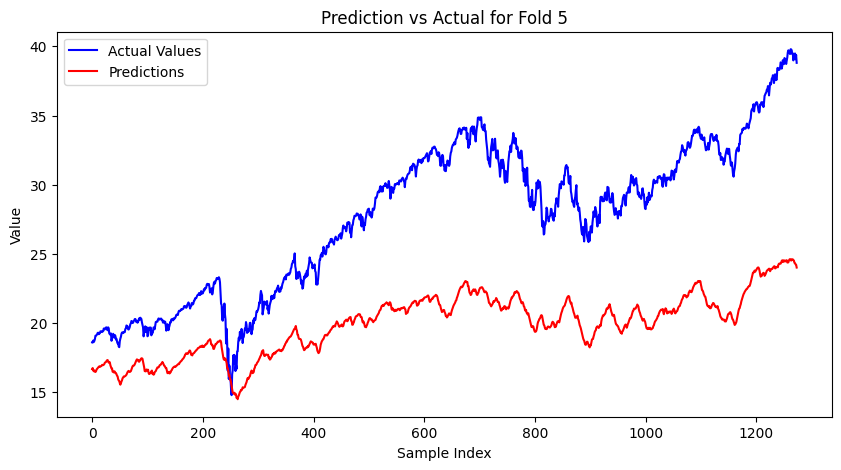

In [50]:
print(f"Total avarage training time: {np.average(times):.2f} seconds")

for fold in range(5):
  history = histories[fold]
  rmse, mape = metrics[fold]
  y_actual, y_hat = predictions[fold]
  print("\n" + "#" * 50)
  print(f"#########  FOLD {fold+1} #########")
  print("#" * 50 + "\n")
  print(f"Model {fold+1}: RMSE = {rmse:.4f}, MAPE = {mape:.4f}")
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'Model Loss for fold {fold + 1}')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()


  plt.figure(figsize=(10, 5))
  plt.plot(y_actual, label='Actual Values', color='blue')
  plt.plot(y_hat, label='Predictions', color='red')
  plt.title(f'Prediction vs Actual for Fold {fold + 1}')
  plt.ylabel('Value')
  plt.xlabel('Sample Index')
  plt.legend()
  plt.show()